In [1]:
import numpy as np

import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import show


from sklearn.datasets import fetch_species_distributions

from sklearn.neighbors import KernelDensity

from scipy import ndimage

import subprocess

In [5]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


In [48]:
# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()

species_names = ["Bradypus Variegatus", "Microryzomys Minutus"]

Xtrain = np.vstack([data["train"]["dd lat"], data["train"]["dd long"]]).T
ytrain = np.array(
    [d.decode("ascii").startswith("micro") for d in data["train"]["species"]],
    dtype="int",
)

Xtrain *= np.pi / 180.0  # Convert lat/long to radians


In [49]:
Xtrain

array([[-0.3115413 , -1.129228  ],
       [-0.28506985, -1.1839144 ],
       [-0.28448865, -1.1847872 ],
       ...,
       [-0.00523599, -1.3695022 ],
       [ 0.01047198, -1.3581576 ],
       [ 0.08668474, -1.3156868 ]], dtype=float32)

In [50]:
# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()


In [51]:
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.0



In [56]:
Xtrain.shape

(1624, 2)

In [57]:
ytrain.shape

(1624,)

In [59]:
xy

array([[ 0.41015237, -1.35699349],
       [ 0.41015237, -1.35263017],
       [ 0.41015237, -1.33081355],
       ...,
       [-0.97738438, -1.17809725],
       [-0.97738438, -1.17373392],
       [-0.97738438, -1.1693706 ]])

 - computing KDE in spherical coordinates


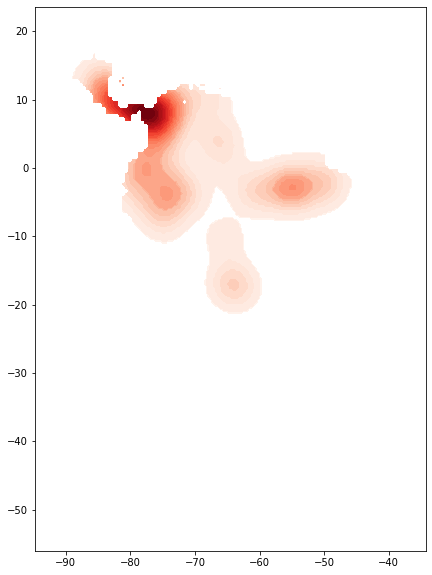

In [54]:
i = 0


# Plot map of South America with distributions of each species
fig = plt.figure(figsize=(7, 10))
# fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

# construct a kernel density estimate of the distribution
print(" - computing KDE in spherical coordinates")
kde = KernelDensity(
    bandwidth=0.04, metric="haversine", kernel="gaussian", algorithm="ball_tree"
)
kde.fit(Xtrain[ytrain == i])

# evaluate only on the land: -9999 indicates ocean
Z = np.full(land_mask.shape[0], -9999, dtype="int")
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(), 25)
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)


In [61]:
x = kde.score_samples(xy)

In [62]:
x


array([ -12.55778545,  -12.81094804,  -13.59322834, ..., -123.01897066,
       -122.49196503, -121.97121808])

In [63]:
x.shape

(28008,)

In [64]:
np.exp(x)

array([3.51741066e-06, 2.73071237e-06, 1.24892380e-06, ...,
       3.74575935e-54, 6.34476455e-54, 1.06800439e-53])

148.4131591025766

## population

In [1]:
import rasterio
import numpy as np

from scipy import ndimage

from rasterio.plot import show


In [2]:
def arr_to_ascii(arr, r_ascii, xll=-180, yll=-90, cellsize=0.25, nodata=-9999):
    """
    Convert a numpy array to an ASCII raster.
    :@param arr:            2D array
    :@param r_ascii:        Full path to outfile with extension
    :@param xll:            Longitude coordinate for lower left corner
    :@param yll:            Latitude coordinate for lower left corner
    :@param cellsize:       Cell size in geographic degrees
    :@param nodata:         Value representing NODATA
    """

    # get number of rows and columns of array
    nrows = arr.shape[0]
    ncols = arr.shape[1]

    # create ASCII raster file
    with open(r_ascii, 'w') as rast:

        # write header
        rast.write('ncols {}\n'.format(ncols))
        rast.write('nrows {}\n'.format(nrows))
        rast.write('xllcorner {}\n'.format(xll))
        rast.write('yllcorner {}\n'.format(yll))
        rast.write('cellsize {}\n'.format(cellsize))
        rast.write('nodata_value {}\n'.format(nodata))

        # write array
        np.savetxt(rast, arr, fmt='%.15g')


In [4]:
pf = "/Users/d3y010/projects/population/data/zoraghein-oneill_population_gravity_inputs_outputs/new_york/outputs/model/SSP5/new york_1km_SSP5_total_2100.tif"

f = "/Users/d3y010/projects/cerf/data/suitability/site_original/population/SITE population 2005/out_grid.asc"


In [13]:
pf = "/Users/d3y010/projects/population/data/zoraghein-oneill_population_gravity_inputs_outputs/new_york/outputs/model/SSP5/new york_1km_SSP5_total_2100.tif"


with rasterio.open(pf) as src:
    
    arr = src.read(1)
    
#     arr = np.where(arr == src.nodata, np.nan, arr)
    
    r_ascii = '/Users/d3y010/Desktop/ex_2100.asc'
    
    arr_to_ascii(arr, r_ascii, xll=src.bounds.left, yll=src.bounds.bottom, cellsize=1000, nodata=src.nodata)


In [40]:
arr.shape

(2762, 3145)

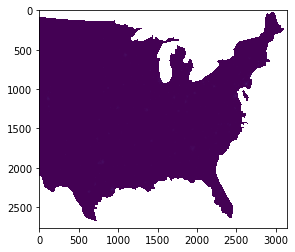

<AxesSubplot:>

In [41]:
show(arr)

In [ ]:
window = np.ones(shape=(8, 8))


In [ ]:
workarr = np.nan_to_num(arr)


In [50]:
def focal_density(x):

    return np.nansum(x) / (8 * 8)


In [ ]:
arx = ndimage.generic_filter(arr, focal_density, footprint=window)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



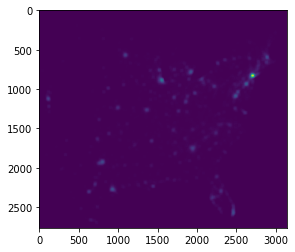

<AxesSubplot:>

In [46]:
show(arx)

In [48]:
with rasterio.open(f) as src:
    
    metadata = src.meta

    with rasterio.open('/Users/d3y010/Desktop/x.tif', 'w', **metadata) as out:
        
        out.write(arx, 1)
    


In [32]:
arx.max()

7312.0703

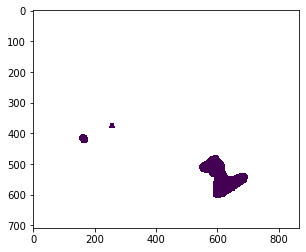

<AxesSubplot:>

In [34]:
arv = np.where(arx >= 400, 1, np.nan)

show(arv)


## Old way

In [57]:
import os
import glob
import shutil
import math
import sys

import rasterio
import numpy as np

from scipy import ndimage
from rasterio.plot import show


f = "/Users/d3y010/projects/population/data/zoraghein-oneill_population_gravity_inputs_outputs/new_york/outputs/model/SSP5/new york_1km_SSP5_total_2100.tif"

r_ascii = '/Users/d3y010/Desktop/ex_2100.asc'

scenario = 'ssp5'

ascii_dir = "/Users/d3y010/projects/cerf/suitability/data/raw/population"

nodata = -999


#### Convert GeoTiff to ASC rasters

In [55]:
for yr in range(2020, 2100 + 5, 5):
    
    print(f"Processing:  {yr}")
    
    f = f"/Users/d3y010/projects/population/data/mosaic/population_conus_total_{scenario}_{yr}_1km.tif"
    
    r_ascii = os.path.join(ascii_dir, f"population_conus_total_{scenario}_{yr}_1km.asc")
    
    with rasterio.open(f) as src:

        arr = src.read(1)

        arr = np.where(arr == src.nodata, nodata, arr)

        # round up to whole numbers
        arr = np.around(arr, 0).astype(np.int)

        arr_to_ascii(arr, r_ascii, xll=src.bounds.left, yll=src.bounds.bottom, cellsize=1000, nodata=nodata)



Processing:  2020
Processing:  2025
Processing:  2030
Processing:  2035
Processing:  2040
Processing:  2045
Processing:  2050
Processing:  2055
Processing:  2060
Processing:  2065
Processing:  2070
Processing:  2075
Processing:  2080
Processing:  2085
Processing:  2090
Processing:  2095
Processing:  2100


In [65]:
def create_buffer(radius):  #radius given in #cells
    
    b = []
    for i in range(radius+1):
        
        for j in range(radius+1):
            
            if math.sqrt(i**2 + j**2) <= radius:
                
                if i==0 and j==0:
                    b.extend([(i,j)])
                elif i==0:
                    b.extend([(i,j),(i,-j)])
                elif j==0:
                    b.extend([(i,j),(-i,j)])
                else:
                    b.extend([(i,j),(-i,j),(i,-j),(-i,-j)])
                    
    return b


def main(ascii_dir, out_dir, scenario, model='SITE', year=2100):
    #----------inputs--------------
#    input_raster = r"C:\Users\schm156\Documents\iRESM population dataset\files-from-Tim\ascii\2100.asc"
#     input_raster = r"F:\New_SITE_layers\population\EIC_pop_2005\out_grid.asc"
#     out_dir = r"F:\New_SITE_layers\population"
# #    model = 'WRF'
#     model = 'SITE'
    #----------inputs--------------
    
    input_raster = os.path.join(ascii_dir, f"population_conus_total_{scenario}_{year}_1km.asc")

    if model == 'SITE':
        buffer_relative = create_buffer(40)        #25 mile (40 km) buffer, SITE version
        buffer_relative.reverse()                   #Look at biggest buffers first
#        print 'Warning: buffer_relative has not yet been defined for SITE'
    elif model == 'WRF':
        buffer_relative = [(0,0),(1,0),(-1,0),(0,1),(0,-1),(2,0),(-2,0),(0,2),(0,-2),(1,1),(1,-1),(-1,1),(-1,-1)]        #WRF version

    unbuffered_file = os.path.join(out_dir, f"cerf_densely_populated_{scenario}_{year}.asc")
    buffered_file = os.path.join(out_dir, f"cerf_densely_populated_{scenario}_{year}_buff25mi.asc")
    nuclear_file = os.path.join(out_dir, f"cerf_densely_populated_{scenario}_{year}_nuclear.asc")

    headers = []
    in_raster_data = []
    unsuitable_cells = []
    unsuitable_shapes = []
    buffered_shapes = []

    print('Loading input raster\n')
    inf = open(input_raster,'r')
    currentline = inf.readline()

    elif model == 'SITE':
        nodata_val = '-999'

    while currentline.split()[0] != nodata_val:
        headers.append(currentline)
        currentline = inf.readline()
    while currentline:
        in_raster_data.append([int(x) for x in currentline.split()])
        currentline = inf.readline()
    inf.close()

#     print( 'Copying projection information\n')
#     for f in [unbuffered_file,buffered_file,nuclear_file]:
#         shutil.copyfile(input_raster[:-3]+'prj',f[:-3]+'prj')

    print( 'Producing unbuffered file\n')
    #produce unbuffered file
    f = open(unbuffered_file,'w')
    for line in headers:
        f.write(line)
        
    for rowi in range(len(in_raster_data)):
        for columni in range(len(in_raster_data[rowi])):
            cell = in_raster_data[rowi][columni]
            if model == 'SITE':
                threshold = 772
                
            if cell > threshold:
                f.write('1 ')
                unsuitable_cells.append((rowi,columni))
                
            elif cell == -9999:
                f.write('1 ')
            else:
                f.write('0 ')
        f.write('\n')
    f.close()

    print( 'Producing buffered file\n')
    print( '...identifying unsuitable blocks')
    if model == 'SITE':
        threshold = 64.75

    while len(unsuitable_cells) > 0:
        start_cell = unsuitable_cells.pop()
        to_check = [start_cell]
        this_shape = [start_cell]
        
        while len(to_check) > 0:
            cell = to_check.pop()
            if (cell[0],cell[1]-1) in unsuitable_cells:
                to_check.append((cell[0],cell[1]-1))
                this_shape.append((cell[0],cell[1]-1))
                unsuitable_cells.remove((cell[0],cell[1]-1))
            if (cell[0],cell[1]+1) in unsuitable_cells:
                to_check.append((cell[0],cell[1]+1))
                this_shape.append((cell[0],cell[1]+1))
                unsuitable_cells.remove((cell[0],cell[1]+1))
            if (cell[0]-1,cell[1]) in unsuitable_cells:
                to_check.append((cell[0]-1,cell[1]))
                this_shape.append((cell[0]-1,cell[1]))
                unsuitable_cells.remove((cell[0]-1,cell[1]))
            if (cell[0]+1,cell[1]) in unsuitable_cells:
                to_check.append((cell[0]+1,cell[1]))
                this_shape.append((cell[0]+1,cell[1]))
                unsuitable_cells.remove((cell[0]+1,cell[1]))
                
        if len(this_shape) > threshold:
            unsuitable_shapes.extend(this_shape)
            
    unsuitable_cells = this_shape = None     #free up memory

    print( '...buffering')
    buffered_shapes = set(buffered_shapes)
    
    for cell in unsuitable_shapes:
        
        for offset in buffer_relative:
            
            try:
                buffered_shapes.add((cell[0]+offset[0], cell[1]+offset[1]))
            except MemoryError:
                print( 'MemoryError: line 121.\n\t len(buffered_shapes) =', len(buffered_shapes))
                print( 'len(in_raster_data) =', len(in_raster_data))
                sys.exit(2)
                
#            buffered_shapes.append((cell[0]+offset[0],cell[1]+offset[1]))
#    buffered_shapes = set(buffered_shapes)

    print( '...printing result\n')
    f = open(buffered_file,'w')
    for line in headers:
        f.write(line)
    for rowi in range(len(in_raster_data)):
        for columni in range(len(in_raster_data[rowi])):
            if (rowi,columni) in buffered_shapes:
                f.write('1 ')
            elif in_raster_data[rowi][columni] == -9999:
                f.write('1 ')
            else:
                f.write('0 ')
        f.write('\n')
    f.close()
    
    unsuitable_shapes = buffered_shapes = None    #free up more memory

    print( 'Producing nuclear file\n')
    if model == 'SITE':
        buffer_relative=[]
#        print 'Warning: buffer_relative has not yet been defined for SITE'
        for i in range(40+1):
            buffer_relative.append(create_buffer(i))
        cell_area = 1
        
    nrows = len(in_raster_data)
    ncolumns = len(in_raster_data[0])
    
    f = open(nuclear_file,'w')
    for line in headers:
        f.write(line)
    for rowi in range(nrows):

        for columni in range(ncolumns):
            suitable = True
            break_flag = False
#             if columni % 1000 == 0:
#                 print( rowi, columni)

            for radius in buffer_relative:
                if not break_flag:
                    totalpop = 0
                    totalarea = 0

                    for offset in radius:
                        new_row = rowi + offset[0]
                        new_column = columni + offset[1]
                        if new_row >= 0 and new_row < nrows and new_column >= 0 and new_column < ncolumns and \
                           in_raster_data[new_row][new_column] != -9999:
                            totalpop += in_raster_data[new_row][new_column]
                            totalarea += cell_area

                    if totalarea != 0:
                        density = float(totalpop)/totalarea
                        if density > 193:
                            suitable = False
                            break_flag = True
                        elif density < 30:
                            break_flag = True
                    else:
                        suitable = False
                        break_flag = True
            if suitable:
                f.write('0 ')
            else:
                f.write('1 ')
        f.write('\n')
    f.close()


    print( 'Done')

In [68]:
from joblib import Parallel, delayed


out_dir = '/Users/d3y010/projects/cerf/suitability/data/technology_specific'
scenarios = ['ssp2', 'ssp3', 'ssp5']


for scenario in scenarios:
    res = Parallel(n_jobs=-1)(delayed(main)(ascii_dir, out_dir, scenario, year=yr) for yr in range(2020, 2100 + 5, 5))



## Convert rasters to the GRIDCERF format

In [15]:
import os
import glob
import json

import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd

from rasterio.mask import mask
from shapely.geometry import box


In [24]:
tech_dir = '/Users/d3y010/projects/cerf/suitability/data/technology_specific'

scenarios = ['ssp2', 'ssp3', 'ssp5']



In [26]:
for scenario in scenarios:

    for yr in range(2020, 2105, 5):

        print(f"Processing {scenario} for {yr}...")

        in_file_standard = os.path.join(tech_dir, f"cerf_densely_populated_{scenario}_{yr}.asc")
        out_file_standard = os.path.join(tech_dir, f"cerf_densely_populated_{scenario}_{yr}.tif")
        
        in_file_buffered = os.path.join(tech_dir, f"cerf_densely_populated_{scenario}_{yr}_buff25mi.asc")
        out_file_buffered = os.path.join(tech_dir, f"cerf_densely_populated_{scenario}_{yr}_buff25mi.tif")
        
        in_file_nuclear = os.path.join(tech_dir, f"cerf_densely_populated_{scenario}_{yr}_nuclear.asc")
        out_file_nuclear = os.path.join(tech_dir, f"cerf_densely_populated_{scenario}_{yr}_nuclear.tif")

        gdal_cmd_standard = f"gdal_translate -projwin -2405552.8355 1609934.7995 2287447.1645 -1389065.2005 -ot Int16 -of GTiff {in_file_standard} {out_file_standard}"
        gdal_cmd_buffered = f"gdal_translate -projwin -2405552.8355 1609934.7995 2287447.1645 -1389065.2005 -ot Int16 -of GTiff {in_file_buffered} {out_file_buffered}"
        gdal_cmd_nuclear = f"gdal_translate -projwin -2405552.8355 1609934.7995 2287447.1645 -1389065.2005 -ot Int16 -of GTiff {in_file_nuclear} {out_file_nuclear}"

        os.system(gdal_cmd_standard)
        os.system(gdal_cmd_buffered)
        os.system(gdal_cmd_nuclear)


Processing ssp2 for 2020...
Processing ssp2 for 2025...
Processing ssp2 for 2030...
Processing ssp2 for 2035...
Processing ssp2 for 2040...
Processing ssp2 for 2045...
Processing ssp2 for 2050...
Processing ssp2 for 2055...
Processing ssp2 for 2060...
Processing ssp2 for 2065...
Processing ssp2 for 2070...
Processing ssp2 for 2075...
Processing ssp2 for 2080...
Processing ssp2 for 2085...
Processing ssp2 for 2090...
Processing ssp2 for 2095...
Processing ssp2 for 2100...
Processing ssp3 for 2020...
Processing ssp3 for 2025...
Processing ssp3 for 2030...
Processing ssp3 for 2035...
Processing ssp3 for 2040...
Processing ssp3 for 2045...
Processing ssp3 for 2050...
Processing ssp3 for 2055...
Processing ssp3 for 2060...
Processing ssp3 for 2065...
Processing ssp3 for 2070...
Processing ssp3 for 2075...
Processing ssp3 for 2080...
Processing ssp3 for 2085...
Processing ssp3 for 2090...
Processing ssp3 for 2095...
Processing ssp3 for 2100...
Processing ssp5 for 2020...
Processing ssp5 for 